## Objective: 
- Derive click-through rate (opened and click link inside email)
- Build a model that can maximize the probability of click-through
- Approximate improvement if model is used
    - Suggest a method for testing for improvement
- Determine trends amongst users

Success(Click-through) = user clicks link inside email

In [1]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the email table
email_df = pd.read_csv('email_table.csv')

# Import the opened emails
email_open = pd.read_csv('email_opened_table.csv')

# Import the clicked links
link_df = pd.read_csv('link_clicked_table.csv')

Notes:
- The opened emails and clicked links tables only have 1 variable each, email_id.
    - These two table will only be used to determine success (opened email and clicked link) at each step
- All user and email information is on the email table.

First, I will make sure the email_id functions as the unique identifier for all the tables. Next, I will check the unique values in the emails table to make sure they are as expected.

In [3]:
# Check to see if email_id is the primary key

# Check the email table
assert email_df['email_id'].nunique() == len(email_df)

# Check the opened emails table
assert email_open['email_id'].nunique() == len(email_open)

# Check the clicked links table
assert link_df['email_id'].nunique() == len(link_df)

Before I set the email_id as the index for all the tables, I want to construct another variable in the tables containing 1's to calculate average success.

In [4]:
# Create an received column in the emails table
email_df['received'] = 1

# Create an opened column in the open emails table
email_open['opened'] = 1

# Create a clicked column in the clicked links table
link_df['clicked'] = 1

In [5]:
# Set the email_ids to the index
email_df.set_index('email_id', inplace=True)
email_open.set_index('email_id', inplace=True)
link_df.set_index('email_id', inplace=True)

In [6]:
# Check the table information of the email_df
email_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 85120 to 348333
Data columns (total 7 columns):
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
received               100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 6.1+ MB


In [7]:
# Check the unique values in the emails table
email_df.nunique()

email_text              2
email_version           2
hour                   24
weekday                 7
user_country            4
user_past_purchases    23
received                1
dtype: int64

In [8]:
for col in email_df.columns:
    print(email_df[col].unique())

['short_email' 'long_email']
['personalized' 'generic']
[ 2 12 11  6 14  9  8  5 23  7 10  3  4  1 13 15 17 16 20 18 19 22 21 24]
['Sunday' 'Wednesday' 'Monday' 'Saturday' 'Friday' 'Tuesday' 'Thursday']
['US' 'UK' 'FR' 'ES']
[ 5  2  1  6  3  8  4  9  0 11 10  7 13 12 18 14 20 15 16 17 19 22 21]
[1]


All the data is within the list of expected values provided. As a result, I feel safe to move onto merging the data to calculate success at each step.

In [9]:
# Create a copy of the email_df for merging
merged_df = email_df.copy()

# Merge the remainder of the tables to the email table with a left merge
for df in [email_open, link_df]:
    merged_df = merged_df.merge(df, how='left', left_index=True, right_index=True)

# Fill all the null entries from the left merge with 0's
merged_df.fillna(0, inplace=True)

In [10]:
# Take a look at the final merged dataframe
merged_df.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases,received,opened,clicked
email_id,,,,,,,,,
85120,short_email,personalized,2,Sunday,US,5,1,0.0,0.0
966622,long_email,personalized,12,Sunday,UK,2,1,1.0,1.0
777221,long_email,personalized,11,Wednesday,US,2,1,0.0,0.0
493711,short_email,generic,6,Monday,UK,1,1,0.0,0.0
106887,long_email,generic,14,Monday,US,6,1,0.0,0.0


Before I build the model to maximize click-through rate, I need to understand how each variable affects the this metric. As a result, I will measure the success between each step of the process and see how that metric changes within each variable.

In [11]:
# Define a function to create dataframes with grouped variables
def create_df(df, cat):
    '''Create dataframes with desired groupings'''
    group_df = df.groupby(cat).sum()
    grouped_df = group_df[['received', 'opened', 'clicked']]
    return grouped_df

In [12]:
# Create a function to calculate the conversion rate between each step and the total
def calculate_steps(df):
    '''Creates columns to calculate success rate between pages and total'''
    df['step1'] = 1
    df['step2'] = df['opened'] / df['received']
    df['step3'] = df['clicked'] / df['opened']
    df['total'] = df['clicked'] / df['received']
    return df

In [13]:
# # Create a function to calculate the total conversion rate at each page
# def calculate_totals(df):
#     '''Creates columns to calculate the total success rate after each page'''
#     df['step1'] = 1
#     df['step2'] = df['opened'] / df['received']
#     df['step3'] = df['clicked'] / df['received']
#     return df

In [14]:
# Define a function to apply the previous 3 functions (no plots will be made)
def create_calculate(df, cat):
    '''Create the dataframe and calculate the success rate between pages and after each page'''
    new_df = create_df(df, cat)
    return calculate_steps(new_df)

In [15]:
# Calculate the final click-through rate at each step
total_df = merged_df.copy()
total_df['merge'] = 1
create_calculate(total_df, 'merge')

,received,opened,clicked,step1,step2,step3,total
merge,,,,,,,
1,100000,10345.0,2119.0,1,0.10345,0.204833,0.02119


In [16]:
# Group by email text 
create_calculate(merged_df, 'email_text')

,received,opened,clicked,step1,step2,step3,total
email_text,,,,,,,
long_email,50276,4584.0,932.0,1,0.091177,0.203316,0.018538
short_email,49724,5761.0,1187.0,1,0.115860,0.206041,0.023872


In [17]:
# Group by email version
create_calculate(merged_df, 'email_version')

,received,opened,clicked,step1,step2,step3,total
email_version,,,,,,,
generic,50209,3984.0,760.0,1,0.079348,0.190763,0.015137
personalized,49791,6361.0,1359.0,1,0.127754,0.213646,0.027294


In [18]:
# Group by email text and version
create_calculate(merged_df, ['email_text', 'email_version'])

received  opened  clicked  step1     step2  \
email_text  email_version                                               
long_email  generic           25236  1787.0    346.0      1  0.070812   
            personalized      25040  2797.0    586.0      1  0.111701   
short_email generic           24973  2197.0    414.0      1  0.087975   
            personalized      24751  3564.0    773.0      1  0.143994   

                              step3     total  
email_text  email_version                      
long_email  generic        0.193621  0.013711  
            personalized   0.209510  0.023403  
short_email generic        0.188439  0.016578  
            personalized   0.216891  0.031231

Notes:
- Interestingly, the length of the email has an effect on if the email is opened.
    - Intuitively, this doesn't make sense as the user doesn't know the length of the email before opening it, therefore it shouldn't have an effect.
    - At this point, I am questioning if the sample is truly random or if the variance is truly that high. Regardless, I will continue with the analysis.
- The version of the email (generic vs. personalized) has a high impact with personalized emails having ~38% increase for opening the email and an additional ~10% increase for click-through rate.
    - Total change of ~44% increase in final click-through rate.
- When paired with short emails, there is a ~39% increase for opening emails and an additional ~13% increase for click-through rate.
    - Total change of ~47% increase in final click-through rate.
- When paired with long emails, there is still an observable ~41% increase in final click-through rate.

In [19]:
# Group by hour 
create_calculate(merged_df, 'hour')

,received,opened,clicked,step1,step2,step3,total
hour,,,,,,,
1,2703,239.0,49.0,1,0.088420,0.205021,0.018128
2,3676,323.0,60.0,1,0.087867,0.185759,0.016322
3,4610,390.0,90.0,1,0.084599,0.230769,0.019523
4,5622,496.0,91.0,1,0.088225,0.183468,0.016186
5,6551,538.0,118.0,1,0.082125,0.219331,0.018013
6,7465,674.0,128.0,1,0.090288,0.189911,0.017147
7,8204,739.0,150.0,1,0.090078,0.202977,0.018284
8,8398,743.0,159.0,1,0.088473,0.213997,0.018933
9,8529,1072.0,220.0,1,0.125689,0.205224,0.025794


Notes:
- Notably, 11PM has a very high click-through rate once the email is opening, yielding a total click-through rate of ~4.1%, which is ~95% increase from the mean.
- 12AM has a high rate of success for opening emails (~54% higher than the mean).
- Overall, there are higher click-through rates from 9AM - 4PM
    - Higher success with email opening from 9AM - 5PM, but strong variance in success with clicking the link.

In [20]:
# Group by weekday 
create_calculate(merged_df, 'weekday')

,received,opened,clicked,step1,step2,step3,total
weekday,,,,,,,
Friday,14177,1051.0,199.0,1,0.074134,0.189343,0.014037
Monday,14363,1667.0,329.0,1,0.116062,0.197361,0.022906
Saturday,14569,1277.0,260.0,1,0.087652,0.203602,0.017846
Sunday,14387,1261.0,241.0,1,0.087649,0.191118,0.016751
Thursday,14277,1691.0,349.0,1,0.118442,0.206387,0.024445
Tuesday,14143,1704.0,352.0,1,0.120484,0.206573,0.024889
Wednesday,14084,1694.0,389.0,1,0.120278,0.229634,0.027620


Notes:
- Monday through Thursday has much higher success with opening emails than the weekends. 
    - ~45% increase in total click-through rate on those work days than the weekends.

In [21]:
# Group by country 
create_calculate(merged_df, 'user_country')

,received,opened,clicked,step1,step2,step3,total
user_country,,,,,,,
ES,9967,390.0,83.0,1,0.039129,0.212821,0.008327
FR,9995,406.0,80.0,1,0.040620,0.197044,0.008004
UK,19939,2396.0,492.0,1,0.120167,0.205342,0.024675
US,60099,7153.0,1464.0,1,0.119020,0.204669,0.024360


Notes:
- Spain and France (countries with the smallest sample size) have very low rates of success for opening the emails, as a result has a low final click-through rate.
- US and UK (~60% and ~20% of the total sample size respectively) have above average rates for opening the email and final click-through rate.

Before I label Spain and France has countries with very low success, let me take a closer look at those two variables.

In [22]:
# # Define a new dataframe for Spain and France
# es_fr = merged_df[(merged_df['user_country'] == 'ES') | (merged_df['user_country'] == 'FR')].copy()

In [23]:
# Group by country and weekday
create_calculate(merged_df, ['user_country', 'weekday'])

received  opened  clicked  step1     step2     step3  \
user_country weekday                                                           
ES           Friday         1371    29.0      6.0      1  0.021152  0.206897   
             Monday         1471    79.0     19.0      1  0.053705  0.240506   
             Saturday       1478    37.0      4.0      1  0.025034  0.108108   
             Sunday         1421    46.0      6.0      1  0.032372  0.130435   
             Thursday       1431    60.0     11.0      1  0.041929  0.183333   
             Tuesday        1402    71.0     21.0      1  0.050642  0.295775   
             Wednesday      1393    68.0     16.0      1  0.048816  0.235294   
FR           Friday         1387    33.0      6.0      1  0.023792  0.181818   
             Monday         1400    77.0     17.0      1  0.055000  0.220779   
             Saturday       1473    52.0     13.0      1  0.035302  0.250000   
             Sunday         1425    48.0      8.0      1  0.033684  0.166667   
             Thursday       1399    69.0     13.0      1  0.049321  0.188406   
             Tuesday        1453    57.0     10.0      1  0.039229  0.175439   
             Wednesday      1458    70.0     13.0      1  0.048011  0.185714   
UK           Friday         2874   272.0     62.0      1  0.094642  0.227941   
             Monday         2864   389.0     62.0      1  0.135824  0.159383   
             Saturday       2937   281.0     60.0      1  0.095676  0.213523   
             Sunday         2858   290.0     66.0      1  0.101470  0.227586   
             Thursday       2801   374.0     73.0      1  0.133524  0.195187   
             Tuesday        2860   387.0     70.0      1  0.135315  0.180879   
             Wednesday      2745   403.0     99.0      1  0.146812  0.245658   
US           Friday         8545   717.0    125.0      1  0.083909  0.174338   
             Monday         8628  1122.0    231.0      1  0.130042  0.205882   
             Saturday       8681   907.0    183.0      1  0.104481  0.201764   
             Sunday         8683   877.0    161.0      1  0.101002  0.183580   
             Thursday       8646  1188.0    252.0      1  0.137405  0.212121   
             Tuesday        8428  1189.0    251.0      1  0.141077  0.211102   
             Wednesday      8488  1153.0    261.0      1  0.135839  0.226366   

                           total  
user_country weekday              
ES           Friday     0.004376  
             Monday     0.012916  
             Saturday   0.002706  
             Sunday     0.004222  
             Thursday   0.007687  
             Tuesday    0.014979  
             Wednesday  0.011486  
FR           Friday     0.004326  
             Monday     0.012143  
             Saturday   0.008826  
             Sunday     0.005614  
             Thursday   0.009292  
             Tuesday    0.006882  
             Wednesday  0.008916  
UK           Friday     0.021573  
             Monday     0.021648  
             Saturday   0.020429  
             Sunday     0.023093  
             Thursday   0.026062  
             Tuesday    0.024476  
             Wednesday  0.036066  
US           Friday     0.014628  
             Monday     0.026773  
             Saturday   0.021081  
             Sunday     0.018542  
             Thursday   0.029146  
             Tuesday    0.029782  
             Wednesday  0.030749

Of the variables studied along with user_country, it seems that France and Spanish simply have lower total click-through rates. 
- Greatest to Least: UK > US > Spain > France
    - France has low click-through rate on all days except Monday
    - Spain has low click-through rates for Friday, Saturday, Sunday, and Thursday
    - US has above above average click-through rates for all days except Friday, Saturday, and Sunday
    - The UK has high click-through rates, peaking on Wednesday.

In [24]:
# Group by user_past_purchases 
create_calculate(merged_df, 'user_past_purchases')

,received,opened,clicked,step1,step2,step3,total
user_past_purchases,,,,,,,
0,13877,532.0,7.0,1,0.038337,0.013158,0.000504
1,13751,1276.0,154.0,1,0.092793,0.120690,0.011199
2,13036,1320.0,200.0,1,0.101258,0.151515,0.015342
3,12077,1305.0,200.0,1,0.108057,0.153257,0.016560
4,10743,1195.0,230.0,1,0.111235,0.192469,0.021409
5,9042,1052.0,201.0,1,0.116346,0.191065,0.022230
6,7518,928.0,241.0,1,0.123437,0.259698,0.032056
7,6051,744.0,186.0,1,0.122955,0.250000,0.030739
8,4393,613.0,174.0,1,0.139540,0.283850,0.039608


In general, total click-through rate is positively correlated with number of past purchases. 

## Summary:
- Short emails have a ~29% increase in total click-through from long emails.
- Personalized emails (with the name of the user) showed a ~44% increase in total click-through from general emails.
- Particular times of the day, namely 9AM - 4PM had a higher click-through rate than the rest of the day (with some irregular exceptions).
- Some days perform particularly better than other days. These days varied between countries.
    - US: all days except Friday, Saturday, and Sunday
    - ES: All days except Thursday through Sunday
    - FR: Only Monday
    - UK: Strong days all week, peaking on Wednesday
- Countries order according to total click-through rate:
    - UK > US > ES > FR
- To note, only the personalized emails affected if the user clicked on the link once the email was open. The rest of the variables only affected if the email would be opened (click rate stayed at a constant ~20% with fluctuations).

### Break:
Since I am currently unable to develop a model that can actively maximize the click-through rate (clustering or deep learning?), I will focus my efforts on calculating the expected change in click-through rate with provided changes. I will also develop a model that can calculate the total conversion rate given a dataset.

In [25]:
# Define the optimal ranges for each variable
TIME = list(np.arange(9, 17))
COUNTRY = ['US', 'UK']
WEEKDAY = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']

In [26]:
# Perform a full grouping
total_groups = create_calculate(merged_df, ['email_text', 'email_version', 'hour',
                                           'weekday', 'user_country'])

# Calculate the total click-through rate within the optimal ranges.
optimal_ctr = total_groups.loc[('short_email', 'personalized', 
                                TIME, WEEKDAY, COUNTRY)]['total'].mean()

mean_ctr = create_calculate(total_df, 'merge')['total'].mean()

# Print the results of the optimization
print('Optimal Click-Through Rate: {}'.format(optimal_ctr))
print('Mean Click-Through Rate: {}'.format(mean_ctr))
print('If we optimize the variables, we can expect to see approximately a {:.2f}% increase in click-through rate.'
      .format((optimal_ctr - mean_ctr) * 100 / mean_ctr))

Optimal Click-Through Rate: 0.04941699359064011
Mean Click-Through Rate: 0.02119
If we optimize the variables, we can expect to see approximately a 133.21% increase in click-through rate.


For the model, I will be using a classification algorithm, named RandomForestClassifier, that will provide a probability of click-throughs given a user's and email's information. When the model is provided with this data, it will provide the probability of the user clicking the link. However, the model needs to be reconfigured if the optimization changes are made to better approximate probability.

In [27]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

# Import train_test_split
from sklearn.model_selection import train_test_split

In [28]:
# Remove the received and opened columns
model_df = merged_df.drop(['received', 'opened'], axis=1)

In [29]:
model_df.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases,clicked
email_id,,,,,,,
85120,short_email,personalized,2,Sunday,US,5,0.0
966622,long_email,personalized,12,Sunday,UK,2,1.0
777221,long_email,personalized,11,Wednesday,US,2,0.0
493711,short_email,generic,6,Monday,UK,1,0.0
106887,long_email,generic,14,Monday,US,6,0.0


In [30]:
# Define the categorical variables to apply LabelEncoder
CATEGORICAL = ['email_text', 'email_version', 'weekday', 'user_country']

# Apply the LabelEncoder
for col in CATEGORICAL:
    model_df[col] = LabelEncoder().fit_transform(model_df[col])

In [31]:
# Define the X and y data
X = model_df.drop(['clicked'], axis=1)
y = model_df['clicked']

# Append the hour column to categorical list
CATEGORICAL.append('hour')

# Create the dummy variables and remove the original column from the X data
for col in CATEGORICAL:
    group_dummies = pd.get_dummies(X[col]).rename(columns=lambda x: col + str(x))
    X = X.join(group_dummies)
    del X[col]
    
# Split the test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [32]:
# Instantiate the RandomForestClassifier with 200 estimators
rf = RandomForestClassifier(n_estimators=200)

# Fit the model with the data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

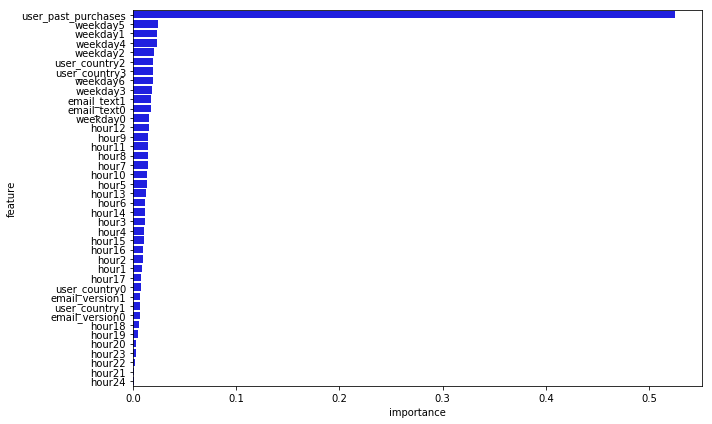

In [33]:
# Extract the feature importances and zip it with the columns into a dataframe# Extrac 
importances = rf.feature_importances_
features = pd.DataFrame({'feature': X.columns, 'importance': importances})
features.sort_values(by='importance', ascending=False, inplace=True)

# Display a horizontal barplot with the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=features['importance'], y=features['feature'], color='blue', orient='h')
plt.tight_layout()

From this visualization, it can be seen that the weekday has country have the highest impact. Surprisingly, the email_text (short or long) has high importance, whereas the email_version (personalized or generalized) has low importance. 

In [34]:
# Predit the test data
predicted_test = rf.predict_proba(X_test)[:, -1]

# Predict the full conversion rate
predicted_click_through = predicted_test.sum() / len(predicted_test)

# print the final result
print ('Predicted Click-Through Rate: {:.2f}%'.format(predicted_click_through * 100))
print ('Actual Click-Through Rate: {:.2f}%'.format(np.mean(y_test) * 100))

Predicted Click-Through Rate: 2.13%
Actual Click-Through Rate: 2.08%


In [35]:
# Print the roc_auc_score
print ('Score:     {}'.format(roc_auc_score(y_test, predicted_test)))

Score:     0.5928246015759522


In [36]:
# Define a function for calculating click-through rate to supplement the model
def calculate_ctr(rfmodel, x_data, y_data):
    '''Calculate the click-through rate from a randomforestclassifier model'''
    # Predit the test data
    predicted_test = rfmodel.predict_proba(x_data)[:, -1]

    # Predict the full conversion rate
    predicted_click_through = predicted_test.sum() / len(predicted_test)
    
    # print the final result
    print ('Predicted Click-Through Rate: {:.2f}%'.format(predicted_click_through * 100))
    print ('Actual Click-Through Rate: {:.2f}%'.format(np.mean(y_data) * 100))

In [37]:
# Make sure the function works as expected.
calculate_ctr(rf, X_test, y_test)

Predicted Click-Through Rate: 2.13%
Actual Click-Through Rate: 2.08%


## Conclusion:
- Click-Through Rate can be optimized for by tweaking the target audience (US and UK), timeframe (Monday - Thursday, 9AM - 4PM), and email format (short, personalized emails).
    - With those changes, we can expect to see at least a 65% increase in total click-through rate.
- The model created can only calculate click-through rate.
    - It's accuracy when classifying click-through success is much lower than expected because the dataset is a very imbalanced (2% target data, 98% control data). 